# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In this exercise, you will implement elements of the t-SNE algorithm described in the paper by Laurens van der Maaten (available on ISIS), and analyze its behavior. As a reminder, here are the main steps of the t-SNE procedure described in the paper:

* compute pairwise affinities $p_{j|i}$ with perplexity perp using $p_{j|i} = \frac{\exp(-||x_i - x_j||^2/2\sigma^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2/2\sigma^2)}$

* Optimize the perplexity for each element i to give the target perplexity (provided in `utils.py`)

* Symmetrize the affinity matrix using $p_{ij} = \frac{p_{j|i}+p_{i|j}}{2N}$

* Consider an initial embedding $Y^{0}$


* Repeat for multiple iterations:

   * Compute the affinities in the embedded space $q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq i}(1 + ||y_i - y_k||^2)^{-1}}$
   
   * Compute the gradient $\frac{\partial C}{\partial Y}$ using $\frac{\partial C}{\partial Y_i} = 4 \sum_{j} (p_{ij}-q_{ij})(y_i-y_j)(1 + ||y_i - y_j||^2)^{-1}$
   
   * Update the embedding using the update rule $Y^{t} = Y^{t-1} + \eta \frac{\partial C}{\partial Y} + \alpha (t)( Y^{t-1}-Y^{t-2})$, where $Y^{t}$ is the value of $Y$ at time $t$, where $Y^{t}=(0,0,...,0)$ for $t < 0$ and where $\alpha (t) = 0.5$ at the beginning of the training procedure and $0.8$ towards the end.
   

* Return the final embedding $Y^{T}$ where $T$ is the number of iterations

## Implementing t-SNE (30P)

You are asked to implement several functions that are used by the t-SNE algorithm. Their specification is given below. In their current form, they simply call functions of the module `solutions`, which is not provided. Replace these calls by your own implementation of the functions. Remark that most of the time, we work with log-probabilities. It is more convenient and numerically stable when the probabilities need to be defined or normalized. (See for example the function `scipy.misc.logsumexp` for that purpose.)

In [1]:
import solutions

import utils
import numpy as np

import scipy,scipy.spatial

def student(Y):
    # Calculate the join log-probabilities log(q_ij) defined above
    #
    # input:  Y    - An Nx2 array containing the embedding
    # return: logQ - An NxN array containing log(q_ij)
    
    D = scipy.spatial.distance.cdist(Y, Y)
    M = np.reciprocal(1 + np.square(D))
    S = np.sum(M - np.diag(np.diag(M)))
    
    return np.log(np.divide(M, S))
    

def objective(logP,logQ):
    # Calculate the objective of t-SNE to minimize. The objective is the
    # KL divergence C = KL(P||Q)
    # 
    # inputs: logP - An NxN array containing log(p_ij)
    #         logQ - An NxN array containing log(q_ij)
    # return: C    - The value of the objective
      
    return np.sum(np.multiply(np.exp(logP), logP - logQ))

def gradient(logP,Y):
    # Computes the gradient as described above.
    #
    #inputs: logP  - An NxN array containing log(p_ij)
    #        Y     - An Nx2 array containing the embedding
    #return: gradY - the gradient of the objective with respect to Y
    
    logQ = student(Y)
                  
    Y_diff = Y[:,np.newaxis,:] - Y[np.newaxis, :, :]
                  
    D = np.reciprocal(1 + np.square(scipy.spatial.distance.cdist(Y, Y)))
    F = np.multiply(np.exp(logP) - np.exp(logQ), D)     
    E = np.multiply(F[:,:,np.newaxis], Y_diff)  
                  
    return 4 * np.sum(E, axis = 1)

The code below implements t-SNE algorithm. It takes as input some unsupervised dataset `X` (a `Nxd` array), and compute a two-dimensional embedding starting from an initial embedding `Y0` (a `Nx2` array). Various training parameters can be specified as optional parameters. The t-SNE algorithm makes use of the functions that are defined above.

In [2]:
import utils
import numpy as np

def TSNE(X,Y0,perplexity=25,learningrate=1.0,nbiterations=250):

    N,d = X.shape
    
    print('get affinity matrix..')
    
    # get the affinity matrix in the original space
    logP = utils.getaffinity(X,perplexity)
    
    # create initial embedding and update direction
    Y  = Y0*1
    dY = Y*0
    
    print('run t-SNE..')
    
    for t in range(nbiterations):

        # compute the pairwise affinities in the embedding space
        logQ = student(Y)
        
        # monitor objective
        #if t %50 == 0: print('%3d %.3f'%(t,objective(logP,logQ)))
        
        # update
        dY = (0.5 if t < 100 else 0.8)*dY + learningrate*gradient(logP,Y)
        Y = Y - dY

    return Y

We test the T-SNE algorithm on the handwritten digits dataset, and compare the found embedding with simple PCA analysis.

Loading digits


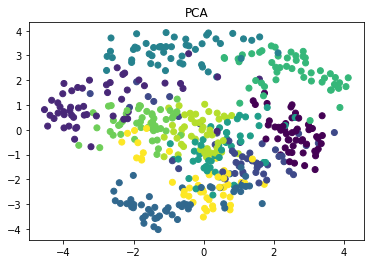

get affinity matrix..
run t-SNE..


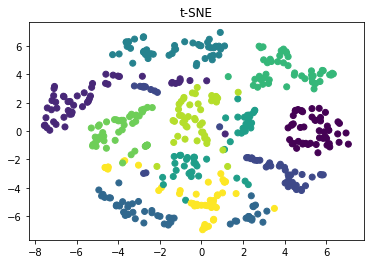

In [3]:
import utils
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# read input dataset
X,color=utils.get_data(mode=1)

# run PCA
U,W,_ = np.linalg.svd(X,full_matrices=False)
Y0 = U[:,:2]*W[:2]
plt.scatter(*Y0.T,c=color); plt.title('PCA')
plt.show()

# run TSNE starting with PCA embedding as an initial solution
Y = TSNE(X,Y0,perplexity=10,learningrate=5.0)
plt.scatter(*Y.T,c=color); plt.title('t-SNE')
plt.show()

## Experimenting With t-SNE (20P)

The file `utils.py` contains a method `get_data(type)` that provides three datasets:

* A collection of digits (less complex than MNIST)
* Boston housing dataset
* Iris dataset

Using your implementation of t-SNE, and running it on the various dataset and with specific training parameters, answer the questions below. Along with your textual answers, include relevant results from running t-SNE in the code cell beneath each question where you should run code with certain parameters (perplexity, learning rate, choice of dataset) relevant to your answer.

How does perplexity and learning rate impact performance? What kind of extreme behaviour these parameters can cause?

**[TODO: write your answer here]**

Setting the perplexity too low or too high can lead to poor performance
In fact, very high or low values perform equally, resulting in a low segmentation margin.

Loading iris


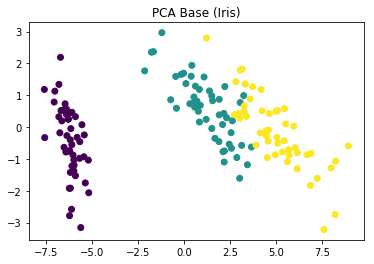

get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..


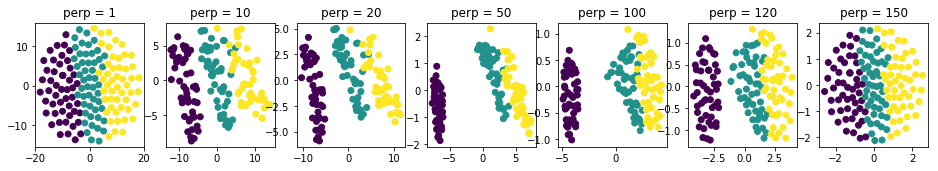

In [6]:
### TODO: write your code here and run it

perpVals = [1, 10, 20, 50, 100, 120, 150]

print ('Setting the perplexity too low or too high can lead to poor performance')
print ('In fact, very high or low values perform equally, resulting in a low segmentation margin.')
print ()

X_iris, C_iris =utils.get_data(mode=3)

# run PCA
U,W,_ = np.linalg.svd(X_iris,full_matrices=False)
Y0 = U[:,:2]*W[:2]
plt.scatter(*Y0.T,c=C_iris); plt.title('PCA Base (Iris)')
plt.show()

fig, axarr = plt.subplots(1, len(perpVals), figsize=(16,16 / len(perpVals)))

for i in range(len(perpVals)):
        
        perp = perpVals[i]
        
        ax = axarr[i]
        ax.set_title('perp = ' + str(perp))

        # run TSNE starting with PCA embedding as an initial solution
        Y = TSNE(X_iris,Y0,perplexity=perp,learningrate=5.0)
        ax.scatter(*Y.T,c=C_iris);
              
plt.show()

Very Small learning rates converge very slow, so for a limited number of iterations the result is basically the initial Embedding
Very high learning rates interestingly keep a meaningful segmentation, but fail to group the data with an acceptable error margin.

Loading digits


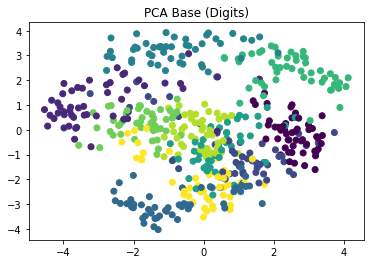

get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..


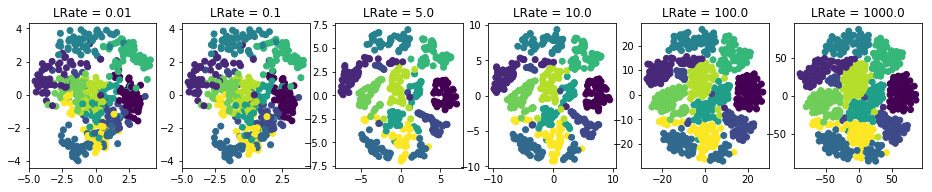

In [5]:
LRateVals = [0.01, 0.1, 5.0, 10.0, 100.0, 1000.0]

print ('Very Small learning rates converge very slow, so for a limited number of iterations the result is basically the initial Embedding')
print ('Very high learning rates interestingly keep a meaningful segmentation, but fail to group the data with an acceptable error margin.')
print ()

X_digits, C_digits =utils.get_data(mode=1)

# run PCA
U,W,_ = np.linalg.svd(X_digits,full_matrices=False)
Y0 = U[:,:2]*W[:2]
plt.scatter(*Y0.T,c=C_digits); plt.title('PCA Base (Digits)')
plt.show()

fig, axarr = plt.subplots(1, len(LRateVals), figsize=(16,16 / len(LRateVals)))

for i in range(len(LRateVals)):
        
        LRate = LRateVals[i]
        
        ax = axarr[i]
        ax.set_title('LRate = ' + str(LRate))

        # run TSNE starting with PCA embedding as an initial solution
        Y = TSNE(X_digits,Y0,perplexity=10,learningrate=LRate)
        ax.scatter(*Y.T,c=C_digits);
              
plt.show()

Very Small learning rates converge very slowly, so for a limited number of iterations the result is basically the initial embedding
Very high learning rates interestingly keep a meaningful segmentation, but fail to group the data with an acceptable error margin.

Loading digits


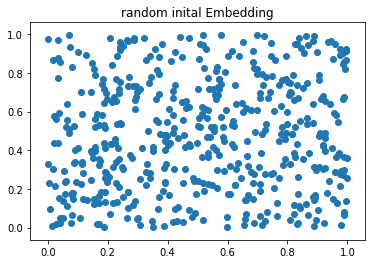

get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..


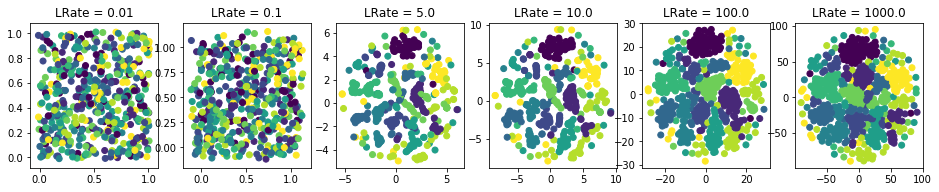

In [10]:
LRateVals = [0.01, 0.1, 5.0, 10.0, 100.0, 1000.0]

print ('Very Small learning rates converge very slowly, so for a limited number of iterations the result is basically the initial embedding')
print ('Very high learning rates interestingly keep a meaningful segmentation, but fail to group the data with an acceptable error margin.')
print ()

X_digits, C_digits =utils.get_data(mode=1)

# random initial embedding
Y0 = np.random.rand(len(X_digits),2)
plt.scatter(Y0[:,0], Y0[:,1]); plt.title('random inital Embedding')
plt.show()

fig, axarr = plt.subplots(1, len(LRateVals), figsize=(16,16 / len(LRateVals)))

for i in range(len(LRateVals)):
        
        LRate = LRateVals[i]
        
        ax = axarr[i]
        ax.set_title('LRate = ' + str(LRate))

        # run TSNE starting with PCA embedding as an initial solution
        Y = TSNE(X_digits,Y0,perplexity=10,learningrate=LRate)
        ax.scatter(*Y.T,c=C_digits);
              
plt.show()

What kind of insight into the dataset you're dealing with can tSNE provide? Show one such example.

**[TODO: write your answer here]**

tSNE shows a lot more groups than PCA. To understand those groups one would have to look at the labels and identify them.
Also, dense lines or loops in the low dimensional representation indicate connections between data points, that are very different pairwise

Loading boston housing


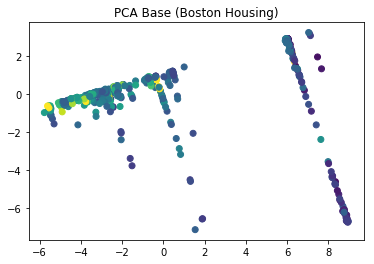

get affinity matrix..
run t-SNE..


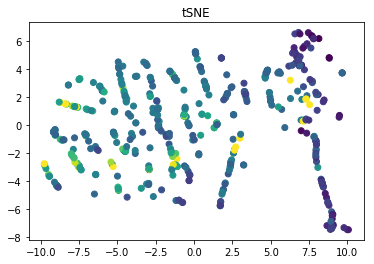

In [11]:
### TODO: write your code here and run it

LRateVals = [0.01, 0.1, 5.0, 10.0, 100.0, 1000.0]

print ('tSNE shows a lot more groups than PCA. To understand those groups one would have to look at the labels and identify them.')
print ('Also, dense lines or loops in the low dimensional representation indicate connections between data points, that are very different pairwise')
print ()

X_housing, C_housing =utils.get_data(mode=2)

# run PCA
U,W,_ = np.linalg.svd(X_housing,full_matrices=False)
Y0 = U[:,:2]*W[:2]
plt.scatter(*Y0.T,c=C_housing); plt.title('PCA Base (Boston Housing)')
plt.show()

# run TSNE starting with PCA embedding as an initial solution
Y = TSNE(X_housing,Y0,perplexity=10,learningrate=5.0)
plt.scatter(*Y.T,c=C_housing); plt.title('tSNE')
plt.show()

How does the embedding evolve during the optimization procedure (i.e. how are the clusters being formed progressively)?

**[TODO: write your answer here]**

The evolution of the Embedding does indeed look like a system of springs that excert a force in order to find a stable state
Loading digits


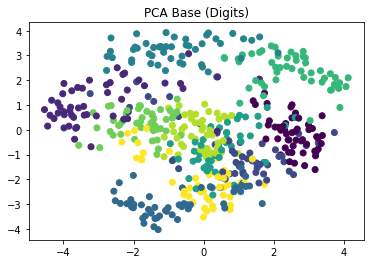

get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..


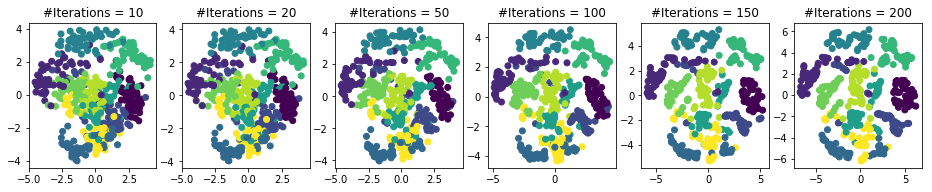

In [13]:
iterCounts = [10, 20, 50, 100, 150, 200]

print ('The evolution of the Embedding does indeed look like a system of springs that excert a force in order to find a stable state')

X_digits, C_digits =utils.get_data(mode=1)

# run PCA
U,W,_ = np.linalg.svd(X_digits,full_matrices=False)
Y0 = U[:,:2]*W[:2]
plt.scatter(*Y0.T,c=C_digits); plt.title('PCA Base (Digits)')
plt.show()

fig, axarr = plt.subplots(1, len(iterCounts), figsize=(16,16 / len(iterCounts)))

for i in range(len(iterCounts)):
        
        iterCount = iterCounts[i]
        
        ax = axarr[i]
        ax.set_title('#Iterations = ' + str(iterCount))

        # run TSNE starting with PCA embedding as an initial solution
        Y = TSNE(X_digits,Y0,perplexity=10,learningrate=5.0, nbiterations=iterCount)
        ax.scatter(*Y.T,c=C_digits);
              
plt.show()

The evolution of the Embedding does indeed look like a system of springs that excert a force in order to find a stable state
Loading digits


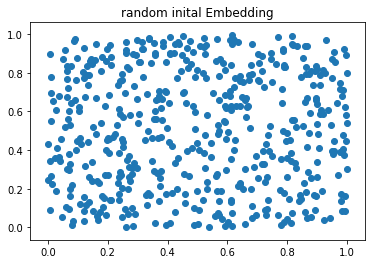

get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..
get affinity matrix..
run t-SNE..


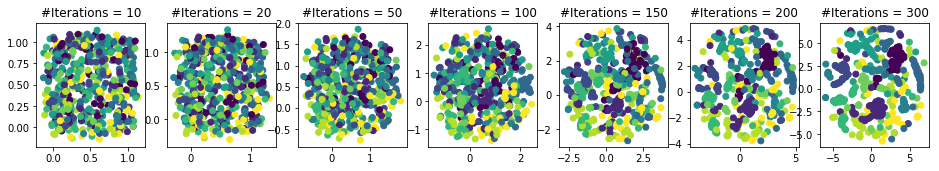

In [14]:
iterCounts = [10, 20, 50, 100, 150, 200, 300]

print ('The evolution of the Embedding does indeed look like a system of springs that excert a force in order to find a stable state')

X_digits, C_digits =utils.get_data(mode=1)

# random initial embedding
Y0 = np.random.rand(len(X_digits),2)
plt.scatter(Y0[:,0], Y0[:,1]); plt.title('random inital Embedding')
plt.show()

fig, axarr = plt.subplots(1, len(iterCounts), figsize=(16,16 / len(iterCounts)))

for i in range(len(iterCounts)):
        
        iterCount = iterCounts[i]
        
        ax = axarr[i]
        ax.set_title('#Iterations = ' + str(iterCount))

        # run TSNE starting with PCA embedding as an initial solution
        Y = TSNE(X_digits,Y0,perplexity=10,learningrate=5.0, nbiterations=iterCount)
        ax.scatter(*Y.T,c=C_digits);
              
plt.show()